## Imports

In [1]:
from collections import OrderedDict
import configparser
from functools import partial
import numpy as np
from shapely import Polygon
import math
from typing import Any
from matplotlib.backend_bases import MouseEvent, MouseButton
from matplotlib.gridspec import GridSpec
from matplotlib import pyplot as plt

import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

from bbtoolkit.preprocessing.environment.viz import plot_arrow, plot_polygon
from bbtoolkit.data import Cached
from bbtoolkit.data.configparser import EvalConfigParser
from bbtoolkit.preprocessing.environment import Environment
from bbtoolkit.preprocessing.environment.compilers import DynamicEnvironmentCompiler
from bbtoolkit.preprocessing.environment.compilers.callbacks import TransparentObjects
from bbtoolkit.preprocessing.environment.utils import env2builder
from bbtoolkit.preprocessing.environment.visible_planes import LazyVisiblePlaneWithTransparancy
from bbtoolkit.preprocessing.neural_generators import TCGenerator
from bbtoolkit.structures.geometry import Texture, TexturedPolygon
from bbtoolkit.dynamics.callbacks import BaseCallback
from bbtoolkit.preprocessing.environment.fov import FOVManager
from bbtoolkit.preprocessing.environment.fov.ego import EgoManager
from bbtoolkit.math import pol2cart
from bbtoolkit.math.geometry import calculate_polar_distance
from bbtoolkit.dynamics import DynamicsManager
from bbtoolkit.dynamics.callbacks.fov import EgoCallback, EgoSegmentationCallback, FOVCallback, ParietalWindowCallback
from bbtoolkit.dynamics.callbacks.movement import MovementCallback, MovementSchedulerCallback, TrajectoryCallback
from bbtoolkit.movement import MovementManager
from bbtoolkit.dynamics.attention import RhythmicAttention
from bbtoolkit.dynamics.callbacks.attention import AttentionCallback
from bbtoolkit.movement.trajectory import AStarTrajectory


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def create_circular_layout(N: int, d: float = 5, figsize: tuple[int, int] = (5, 5)):
    """
    Creates a circular layout for a matplotlib figure with N axes.

    Parameters:
    - N: The number of axes to create in the circular layout.

    Returns:
    - fig: The matplotlib figure object.
    - axs: A list of polar axes.
    """
    fig = plt.figure(figsize=figsize)
    axs = []
    gs = GridSpec(int(2*d*1000 + 500), int(2*d*1000 + 500), figure=fig)
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)

    max_a, max_b = 0, 0

    for i in range(N):
        # Calculate the angle for each subplot

        # Set the position of the subplot
        a = int((d*np.cos(theta[i]) + d) * 500)
        b = int((d*np.sin(theta[i]) + d) * 500)

        if a > max_a:
            max_a = a
        if b > max_b:
            max_b = b

        ax = fig.add_subplot(gs[a:a+1000, b:b+1000], projection='3d')

        axs.append(ax)
    axs = [
        fig.add_subplot(gs[
            max_a//2: max_a//2 + 1000,
            max_b//2: max_b//2 + 1000
        ], polar=True)
    ] + axs

    return fig, axs


### Define Transformation Circuit and Environment

In [3]:
from bbtoolkit.preprocessing.neural_generators import MTLGenerator


hd_config_path = '../cfg/cells/hd_cells.ini'
hd_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
hd_config.read(hd_config_path)

mtl_config_path = '../cfg/cells/mtl_cells.ini'
mtl_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
mtl_config.read(mtl_config_path)

tr_config_path = '../cfg/cells/transformation_circuit.ini'
tr_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
tr_config.read(tr_config_path)

env_cfg = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
env_cfg.read('../cfg/envs/squared_room.ini')

space_cfg = mtl_config['Space']
h_res = space_cfg.eval('res')
r_max = space_cfg.eval('r_max')

mtl_grid_cfg = mtl_config['PolarGrid']
n_radial_points = mtl_grid_cfg.eval('n_radial_points')
polar_dist_res = mtl_grid_cfg.eval('polar_dist_res')
polar_ang_res = mtl_grid_cfg.eval('polar_ang_res', locals={'pi': np.pi})
h_sig = mtl_grid_cfg.eval('sigma_hill')

tr_space_cfg = tr_config['Space']
tr_res = tr_space_cfg.eval('tr_res', locals={'pi': np.pi})
res = tr_space_cfg.eval('res')

n_steps = tr_config['Training'].eval('n_steps')

hd_neurons_cfg = hd_config['Neurons']
sigma_angular = hd_neurons_cfg.eval('sigma', locals={'pi': np.pi})
n_hd = hd_neurons_cfg.eval('n_neurons')


training_rect_cfg = env_cfg['TrainingRectangle']
max_train_x = training_rect_cfg.eval('max_train_x')
min_train_x = training_rect_cfg.eval('min_train_x')
max_train_y = training_rect_cfg.eval('max_train_y')
min_train_y = training_rect_cfg.eval('min_train_y')

env = Environment.load('../data/envs/main_environment.pkl')

tc_gen = TCGenerator(
    n_hd,
    tr_res,
    res,
    r_max,
    polar_dist_res,
    n_radial_points,
    polar_ang_res,
    sigma_angular,
    n_steps=n_steps
)

mtl_gen = MTLGenerator(
    r_max, h_sig, polar_dist_res, polar_ang_res, env
)

builder = env2builder(env)
cache_manager = Cached(cache_storage=OrderedDict(), max_size=10000)
compiler = DynamicEnvironmentCompiler(
    builder,
    partial(
        LazyVisiblePlaneWithTransparancy,
        cache_manager=cache_manager,
    ),
    callbacks=TransparentObjects()
)

compiler.add_object(
    TexturedPolygon(
        Polygon([
            (-5, -5),
            (-6, -5),
            (-6, -6),
            (-5, -6)
        ]),
        texture=Texture(
            id_=31,
            color='#ffd200',
            name='main_object'
        )
    ),
    TexturedPolygon(
        Polygon([
            (-7, -7),
            (-8, -7),
            (-8, -8),
            (-7, -8)
        ]),
        texture=Texture(
            id_=32,
            color='#ffd200',
            name='main_object'
        )
    ),
    TexturedPolygon(
        Polygon([
            (2, 2),
            (1, 2),
            (1, 1),
            (2, 1)
        ]),
        texture=Texture(
            id_=33,
            color='#ffd200',
            name='main_object'
        )
    ),
    TexturedPolygon(
        Polygon([
            (-2, 2),
            (-1, 2),
            (-1, 1),
            (-2, 1)
        ]),
        texture=Texture(
            id_=34,
            color='#ffd200',
            name='main_object'
        )
    ),
    TexturedPolygon(
        Polygon([
            (7, 7),
            (6, 7),
            (6, 6),
            (7, 6)
        ]),
        texture=Texture(
            id_=35,
            color='#ffd200',
            name='main_object'
        )
    )
)

In [4]:
from bbtoolkit.structures.synapses import DirectedTensorGroup, dict2directed_tensor

def connectivity_config2dict(
    config: EvalConfigParser,
    populations: tuple[str, ...] = None,
    ignore: tuple[str, ...] = None
) -> dict[str, dict[str, Any]]:
    """
    Converts EvalConfigParser object into a nested dictionary with specified sections and populations.

    Args:
        config (EvalConfigParser): An instance of EvalConfigParser containing configuration data.
        populations (tuple[str, ..], optional): A tuple of sections to include.
            If None, read all sections except of 'ExternalSources' and 'Hyperparameters'. Defaults to None.
        ignore (tuple[str, ..], optional): A tuple of sections to ignore. 'ExternalSources' and 'Hyperparameters' sections are always ignored. Defaults to None.

    Returns:
        dict[str, dict[str, Any]]: A nested dictionary containing configuration data organized by sections and populations.
    """
    if populations is None:
        populations = tuple(config.sections())

    if ignore is None:
        ignore = {'ExternalSources', 'Hyperparameters'}
    else:
        ignore = set(list(ignore) + ['ExternalSources', 'Hyperparameters'])

    out = {
        config.optionxform(section): {
            population: config.eval(section, population)
            for population in config[section]
        }
        for section in config.sections() if section in populations and section not in ignore
    }
    return out


config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
config.read('../cfg/connectivity/main.ini')

configdict = connectivity_config2dict(config)
connections = dict2directed_tensor(configdict)
connectivity = DirectedTensorGroup(*connections)

position = 1, -5
# direction = -np.pi/2
direction = 0
fov_angle = np.pi*.9
fov_manager = FOVManager(compiler.environment, fov_angle)
ego_manager = EgoManager(fov_manager)

cache = {'env': compiler.environment, 'tc_gen': tc_gen}
dt = 0.01
n_objects = 5

polar_distance = calculate_polar_distance(tc_gen.r_max)
polar_angle = np.linspace(0, (tc_gen.n_bvc_theta + 1) * tc_gen.polar_ang_res, tc_gen.n_bvc_theta)
polar_distance, polar_angle = np.meshgrid(polar_distance, polar_angle)
pdist, pang = polar_distance, polar_angle
x_bvc, y_bvc = pol2cart(pdist, pang)
hd_polar_res = 2 * np.pi / n_hd
hd_angles = np.arange(0, 2 * np.pi+ hd_polar_res, hd_polar_res) + np.pi/2
hd_dist, hd_ang = np.meshgrid(np.array([1, 1.5]), hd_angles)
hd_x, hd_y = pol2cart(hd_dist, hd_ang)

In [5]:
from bbtoolkit.preprocessing.neural_generators import GCMap


mtl_weights = DirectedTensorGroup.load('../data/weights/mtl_weights.pkl')
tc_weights = DirectedTensorGroup.load('../data/weights/tc_weights.pkl')
# tc_weights = DirectedTensorGroup.load('../data/weights/tc_weights_90_deg.pkl')
hd_weights = DirectedTensorGroup.load('../data/weights/hd_weights.pkl')
pc_weights = DirectedTensorGroup.load('../data/weights/pc_weights.pkl')
gc_map = GCMap.load('../data/weights/gc_map.pkl')

weights = mtl_weights + tc_weights + hd_weights + pc_weights

n_h_neurons = len(weights.h.to.h)
n_bvc_neurons = n_opw_neurons = n_ovc_neurons = len(weights.bvc.to.bvc)
n_pr_neurons = len(weights.pr.to.pr)
n_hd_neurons = len(weights.hd.to.hd)
n_pc_neurons = len(weights.gc.to.h)
n_gc_neurons = len(weights.gc.to.h.T)
n_tc_layers = len(weights.tr.to.pw.T)

In [6]:
from bbtoolkit.structures.synapses import DirectedTensor


tr_projection = DirectedTensorGroup(
    DirectedTensor(
        from_='bvc',
        to='tr',
        weights=np.eye(n_bvc_neurons)
    ),
    DirectedTensor(
        from_='tr',
        to='bvc',
        weights=np.eye(n_bvc_neurons)
    )
)

new_pathways = DirectedTensorGroup(
    DirectedTensor(
        from_='h',
        to='opr',
        weights=np.zeros((n_objects, n_h_neurons))
    ),
    DirectedTensor(
        from_='opr',
        to='h',
        weights=np.zeros((n_h_neurons, n_objects))
    ),
    DirectedTensor(
        from_='h',
        to='ovc',
        weights=np.zeros((n_ovc_neurons, n_h_neurons))
    ),
    DirectedTensor(
        from_='ovc',
        to='h',
        weights=np.zeros((n_h_neurons, n_ovc_neurons))
    ),
    DirectedTensor(
        from_='ovc',
        to='ovc',
        weights=np.zeros((n_ovc_neurons, n_ovc_neurons))
    ),
    DirectedTensor(
        from_='bvc',
        to='ovc',
        weights=np.zeros((n_ovc_neurons, n_bvc_neurons))
    ),
    DirectedTensor(
        from_='ovc',
        to='bvc',
        weights=np.zeros((n_bvc_neurons, n_ovc_neurons))
    ),
    DirectedTensor(
        from_='opw',
        to='opw',
        weights=np.zeros((n_opw_neurons, n_opw_neurons))
    ),
    DirectedTensor(
        from_='ovc',
        to='opr',
        weights=np.zeros((n_objects, n_ovc_neurons))
    ),
    DirectedTensor(
        from_='opr',
        to='ovc',
        weights=np.zeros((n_ovc_neurons, n_objects))
    ),
    DirectedTensor(
        from_='opr',
        to='pw',
        weights=np.zeros((n_opw_neurons, n_objects))
    ),
    DirectedTensor(
        from_='opr',
        to='hd',
        weights=np.zeros((n_hd_neurons, n_objects))
    ),
    DirectedTensor(
        from_='bvc',
        to='opr',
        weights=np.zeros((n_objects, n_bvc_neurons))
    ),
    DirectedTensor(
        from_='opr',
        to='bvc',
        weights=np.zeros((n_bvc_neurons, n_objects))
    ),
    DirectedTensor(
        from_='opr',
        to='opr',
        weights=np.zeros((n_objects, n_objects))
    ),
)

In [7]:
weights += tr_projection
weights += new_pathways

weights = weights.operation_with(connectivity, lambda a, b: a - b.get('inhibitory_phi', 0), on_missing_weights='ignore', on_missing_sources='ignore')

In [8]:
from bbtoolkit.math.geometry import points2segments
from bbtoolkit.structures.synapses import NamedTensor, TensorGroup


activity = TensorGroup(
    NamedTensor('h', np.zeros((n_h_neurons, 1))),
    NamedTensor('bvc', np.zeros((n_bvc_neurons, 1))),
    NamedTensor('pr', np.zeros((n_pr_neurons, 1))),
    NamedTensor('pw', np.zeros((n_bvc_neurons, 1))),
    NamedTensor('hd', np.zeros((n_hd_neurons, 1))),
    NamedTensor('ovc', np.zeros((n_ovc_neurons, 1))),
    NamedTensor('opw', np.zeros((n_opw_neurons, 1))),
    NamedTensor('opr', np.zeros((n_objects, 1))),
    NamedTensor('tr', np.zeros((n_tc_layers, n_bvc_neurons, 1))),
    NamedTensor('otr', np.zeros((n_tc_layers, n_bvc_neurons, 1)))
)

walls_ego, objects_ego = ego_manager(position, direction)
wall_segments = np.concatenate([points2segments(wall) for wall in walls_ego if wall.size])
ego_input_walls = tc_gen.get_grid_activity(wall_segments)
hd_cue_init = 40*tc_gen.get_hd_activity(np.array([direction]))
hd_cue = np.zeros_like(hd_cue_init)
ohd_cue = hd_cue.copy()
pr_cue = np.zeros((n_pr_neurons, 1))

k_ratio = TensorGroup(
    NamedTensor('h', np.zeros((n_h_neurons, 1))),
    NamedTensor('bvc', np.zeros((n_bvc_neurons, 1))),
    NamedTensor('pr', np.zeros((n_pr_neurons, 1))),
    NamedTensor('opr', np.zeros((n_objects, 1))),
    NamedTensor('hd', np.zeros((n_hd_neurons, 1))),
    NamedTensor('pw', np.expand_dims(40*ego_input_walls, 1)), # FIXME: why 40?
    NamedTensor('ovc', np.zeros((n_ovc_neurons, 1))),
    NamedTensor('opw', np.zeros((n_opw_neurons, 1))),
    NamedTensor('tr', np.zeros((n_tc_layers, n_bvc_neurons, 1))),
    NamedTensor('otr', np.zeros((n_tc_layers, n_bvc_neurons, 1))),
)

activity.pw += dt/connectivity.pw.to.pw['tau']*k_ratio.pw

In [9]:
def activity2rate(activity: TensorGroup, connectivity: DirectedTensorGroup) -> TensorGroup:
    """
    Converts the activity of a TensorGroup to firing rates using a sigmoid projection.

    Args:
        activity (TensorGroup): The activity of the neurons.
        connectivity (DirectedTensorGroup): The synaptic connectivity between the neurons.

    Returns:
        TensorGroup: The firing rates of the neurons.
    """
    rates = TensorGroup()
    for key, tensor in activity.data.items():
        key_ = 'pr' if 'pr' in key else key # object identity cells, use same beta and alpha as other PR neurons by definition
        rates.add_tensor(
            NamedTensor(
                key,
                1/(
                    1 + np.exp(-2*connectivity[key_, key_]['beta']*(tensor - connectivity[key_, key_]['alpha']))
                )
            )
        )
    return rates

In [10]:
rates = activity2rate(activity, connectivity)
rates.add_tensor(NamedTensor('gc', np.array([])))
rates.add_tensor(NamedTensor('ip', np.array([])))

### Define callback for plotting

In [11]:
from typing import Mapping


class PlottingCallback(BaseCallback):
    """
    A callback class designed for plotting and visualizing various aspects of a simulation environment and agent behavior.

    This callback integrates with matplotlib to create a multi-panel figure that visualizes the environment, the agent's
    field of view (FOV), ego-centric representation, parietal window (PW) representation, and the agent's trajectory. It
    allows for interactive target setting through mouse clicks on the plot.

    Attributes:
        x_bvc (np.ndarray): The x-coordinates for plotting the BVC (Boundary Vector Cell) activity in the PW representation.
        y_bvc (np.ndarray): The y-coordinates for plotting the BVC activity in the PW representation.
        update_rate (int): The rate at which the plots are updated (every `update_rate` simulation steps).

    Args:
        x_bvc (np.ndarray): The x-coordinates for the BVC activity plot.
        y_bvc (np.ndarray): The y-coordinates for the BVC activity plot.
        update_rate (int, optional): The update rate for the plots. Defaults to 100.

    Methods:
        set_cache(cache: Any):
            Sets the cache for the callback and initializes required keys for plotting.

        on_click(event: KeyEvent):
            Handles mouse click events on the plot for setting movement and rotation targets.

        on_step_end(step: int):
            Updates the plots at the end of each simulation step, based on the specified update rate.

        on_simulation_end(n_cycles_passed: int):
            Closes the plot window at the end of the simulation.

        plot():
            Generates and updates all subplots within the figure.

        clean_axes():
            Clears and resets the axes for the next plot update.

        plot_environment():
            Plots the environment, including walls and objects.

        plot_fov():
            Plots the agent's field of view, showing visible walls and objects.

        plot_ego():
            Plots the ego-centric representation of walls and objects.

        plot_agent():
            Plots the agent's current position and direction.

        plot_pw():
            Plots the parietal window representation of walls and objects.

        plot_trajectory():
            Plots the agent's current trajectory towards a target.
    """
    def __init__(
        self,
        x_bvc: np.ndarray,
        y_bvc: np.ndarray,
        update_rate: int = 10
    ):
        """
        Initializes the PlottingCallback object.

        Args:
            x_bvc (np.ndarray): The x-coordinates for the BVC activity plot.
            y_bvc (np.ndarray): The y-coordinates for the BVC activity plot.
            update_rate (int, optional): The update rate for the plots. Defaults to 100.
        """
        super().__init__()
        self.x_bvc = x_bvc
        self.y_bvc = y_bvc
        self.update_rate = update_rate
        self.step = None
        # Create a figure and a plot
        self.fig = plt.figure(figsize=(10, 5))
        # Create a GridSpec layout
        self.gs = GridSpec(12, 12, figure=self.fig)

        # Add the first subplot on the left side (spanning two rows)
        self.ax1 = self.fig.add_subplot(self.gs[:6, :5])

        # Add the second subplot on the top right
        self.ax2 = self.fig.add_subplot(self.gs[:3, 6:9])

        # Add the third subplot on the bottom right with 3D projection
        self.ax3 = self.fig.add_subplot(self.gs[6:, 6:9], projection='3d')

        # self.ax4 = self.fig.add_subplot(self.gs[7:10, 8:10])
        self.ax4 = self.fig.add_subplot(self.gs[6:, 9:12], projection='3d')

        # self.ax5 = self.fig.add_subplot(self.gs[10:, 6:12], projection='polar')
        self.ax5 = self.fig.add_subplot(self.gs[10:, 6:9])

        self.ax6 = self.fig.add_subplot(self.gs[4:7, 6:9], projection='polar')

        # self.ax7 = self.fig.add_subplot(self.gs[3:6, 9:12], projection='3d')
        self.ax7 = self.fig.add_subplot(self.gs[:5, 8:12], projection='3d')

        self.ax8 = self.fig.add_subplot(self.gs[10:, 9:12])

        self.ax9 = self.fig.add_subplot(self.gs[5:8, 9:12], projection='3d')

        self.ax10 = self.fig.add_subplot(self.gs[7:10, :3])
        self.ax11 = self.fig.add_subplot(self.gs[7:10, 3:6])

        # plt.subplots_adjust(bottom=0.2)

        # Set the limits of the plot
        self.clean_axes()

        # # Connect the key press event to the handler
        # self.fig.canvas.mpl_connect('key_press_event', self.on_key)
        self.fig.canvas.mpl_connect('button_press_event', self.on_click)

    def set_cache(self, cache: Mapping):
        """
        Sets the cache for the callback and initializes required keys for plotting.

        Args:
            cache (Any): The cache to be set for the callback.
        """
        super().set_cache(cache)
        self.cache['move_target'] = None
        self.cache['rotate_target'] = None
        self.requires = [
            'env',
            'tc_gen',
            'move_target',
            'rotate_target',
            'walls_fov',
            'objects_fov',
            'walls_ego',
            'objects_ego',
            'walls_ego_segments',
            'objects_ego_segments',
            'walls_pw',
            'objects_pw',
            'position',
            'direction',
            'movement_schedule',
            'trajectory',
            'attend_to',
            'attention_priority',
            'hd_cue'
        ]

    def on_click(self, event: MouseEvent):
        """
        Handles mouse click events on the plot for setting movement and rotation targets.

        Args:
            event (MouseEvent): The mouse click event on the plot.
        """
        self.plot()

        if event.inaxes is self.ax1:

            if event.button is MouseButton.LEFT:
                self.ax1.plot(event.xdata, event.ydata, 'rx')
                self.fig.canvas.draw()
                plt.pause(.00001)
                self.cache['move_target'] = event.xdata, event.ydata
                self.cache['rotate_target'] = None
            elif event.button is MouseButton.RIGHT:
                self.ax1.plot(event.xdata, event.ydata, 'co')
                self.fig.canvas.draw()
                plt.pause(.00001)
                self.cache['rotate_target'] = event.xdata, event.ydata
                self.cache['move_target'] = None

    def on_step_end(self, step: int):
        """
        Updates the plots at the end of each simulation step, based on the specified update rate.

        Args:
            step (int): The current simulation step.
        """

        if not step % self.update_rate:

            self.plot()

        self.step = step

    def on_simulation_end(self):
        """
        Closes the plot window at the end of the simulation.

        Args:
            n_cycles_passed (int): The number of simulation cycles that have passed.
        """
        plt.close()

    def plot(self):
        """
        Generates and updates all subplots within the figure.
        """
        self.clean_axes()
        self.plot_environment()
        if self.cache['move_target'] is not None:
            self.ax1.plot(*self.cache['move_target'], 'rx')
        if self.cache['rotate_target'] is not None:
            self.ax1.plot(*self.cache['rotate_target'], 'co')
        self.plot_trajectory()
        self.plot_fov()
        self.plot_ego()
        self.plot_agent()
        self.plot_pw()
        self.plot_hd_ring()
        self.fig.canvas.draw()
        plt.pause(.00001)

    def clean_axes(self):
        """
        Clears and resets the axes for the next plot update.
        """
        self.ax1.clear()
        self.ax2.clear()
        self.ax3.clear()
        self.ax4.clear()
        self.ax5.clear()
        self.ax6.clear()
        self.ax7.clear()
        self.ax8.clear()
        self.ax9.clear()
        self.ax10.clear()
        self.ax11.clear()

        self.ax1.set_xlim(-10, 10)
        self.ax1.set_ylim(-10, 10)
        self.ax2.set_xlim(-15, 15)
        self.ax2.set_ylim(-1, 15)

        self.ax3.view_init(azim=-90, elev=90)
        # self.ax3.view_init(azim=-90, elev=60)
        self.ax3.set_axis_off()
        self.ax3.set_zlim(0, 1)
        # self.ax4.view_init(azim=-90, elev=90)
        self.ax4.view_init(azim=-90, elev=60)
        # self.ax4.set_axis_off()
        self.ax4.set_zlim(0, 1)

        # self.ax5.set_theta_zero_location('E')
        # self.ax5.set_theta_direction(-1)
        # self.ax5.set_xticks(np.linspace(0, 2*np.pi, 4, endpoint=False))
        # self.ax5.set_xticklabels(['0°', '270°', '180°', '90°'])

        self.ax6.set_theta_zero_location('E')
        self.ax6.set_theta_direction(-1)
        self.ax6.set_xticks(np.linspace(0, 2*np.pi, 4, endpoint=False))
        self.ax6.set_xticklabels(['0°', '270°', '180°', '90°'])
        self.ax6.axes.get_yaxis().set_visible(False)

        # self.ax7.view_init(azim=-90, elev=90)
        self.ax7.view_init(azim=0, elev=90)
        # self.ax7.view_init(azim=0, elev=60)
        self.ax7.set_zlim(0, 1)
        self.ax7.set_axis_off()
        self.ax7.set_facecolor((0.0, 0.0, 0.0, 0))
        # self.ax9.view_init(azim=0, elev=90)
        self.ax9.view_init(azim=0, elev=60)
        self.ax9.set_zlim(0, 1)
        # self.ax9.set_axis_off()
        self.ax9.set_facecolor((0.0, 0.0, 0.0, 0))

    def plot_hd_ring(self):
        """
        Plots the HD ring activity.
        """
        if self.cache['hd_cue'] is not None:
            theta = np.linspace(0, 2*np.pi, len(self.cache['hd_cue']))
            # self.ax5.plot(theta, self.cache['hd_cue'][::-1], 'b-')
            self.ax10.plot(self.cache['rates'].h)
            # self.ax5.plot(self.cache['activity'].h)
            self.ax11.imshow(np.reshape(self.cache['rates'].h, (66, 66)))
            # self.ax5.imshow(np.reshape(self.cache['activity'].h, (66, 66)))
            self.ax5.plot(self.cache['rates'].pr, 'o')
            self.ax8.plot(self.cache['activity'].opr, 'o')


            # self.ax6.plot(theta, np.squeeze(self.cache['rates'].hd)[::-1], 'b-')
            low = np.ones(len(self.cache['hd_cue']))/2
            high = np.squeeze(self.cache['rates'].hd)
            fill_condition = np.where(high >= low, high, low)
            # self.ax6.plot(theta, low, 'r-')
            self.ax6.fill(np.concatenate([theta, theta[::-1]]), np.concatenate([low, fill_condition]), color='red', alpha=0.5)


    def plot_environment(self):
        """
        Plots the environment, including walls and objects.
        """
        for obj in self.cache['env'].objects + self.cache['env'].walls:
            plot_polygon(obj.polygon, ax=self.ax1, alpha=0.5, linewidth=1)

    def plot_fov(self):
        """
        Plots the agent's field of view, showing visible walls and objects.
        """
        if self.cache['walls_fov']:
            for wall, poly in zip(self.cache['walls_fov'], self.cache['env'].walls):
                self.ax1.plot(wall[:, 0], wall[:, 1], 'o', color=poly.polygon.texture.color, markersize=2)
        if self.cache['objects_fov']:
            for i, (obj, poly) in enumerate(zip(self.cache['objects_fov'], self.cache['env'].objects)):
                if self.cache['attend_to'] is not None and i == self.cache['attend_to']:
                    self.ax1.plot(obj[:, 0], obj[:, 1], 'o', color='r', markersize=3)
                else:
                    self.ax1.plot(obj[:, 0], obj[:, 1], 'o', color=poly.polygon.texture.color, markersize=2)
        dt = self.cache['dt']
        self.ax1.text(-10, 10, f'Time: {(self.step + 1)*dt} s')

    def plot_ego(self):
        """
        Plots the ego-centric representation of walls and objects.
        """
        _ = plot_arrow(np.pi/2, 0, -.75, ax=self.ax2)

        if self.cache['walls_ego_segments']:
            for segments, poly in zip(self.cache['walls_ego_segments'], self.cache['env'].walls):
                for seg in segments:
                    x_start, y_start, x_end, y_end = seg
                    self.ax2.plot([x_start, x_end], [y_start, y_end], color=poly.polygon.texture.color, linewidth=1)

        if self.cache['objects_ego_segments']:
            for i, (segments, poly) in enumerate(zip(self.cache['objects_ego_segments'], self.cache['env'].objects)):
                color = 'r' if self.cache['attend_to'] is not None and i == self.cache['attend_to'] else poly.polygon.texture.color
                for seg in segments:
                    x_start, y_start, x_end, y_end = seg
                    self.ax2.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=1)

    def plot_agent(self):
        """
        Plots the agent's current position and direction.
        """
        if self.cache['position'] is not None and self.cache['direction'] is not None:
            self.ax1.plot(*self.cache['position'], 'bo')
            self.ax1.arrow(*self.cache['position'], 0.5 * math.cos(self.cache['direction']), 0.5 * math.sin(self.cache['direction']))

    def plot_pw(self):
        """
        Plots the parietal window representation of walls and objects.
        """
        # if self.cache['walls_pw'] is not None:
        #     self.ax3.plot_surface(
        #         self.x_bvc,
        #         self.y_bvc,
        #         np.reshape(np.sum(self.cache['walls_pw'], axis=0), (self.cache['tc_gen'].n_bvc_theta, self.cache['tc_gen'].n_bvc_r)),
        #         cmap='coolwarm'
        #     )
        self.ax3.plot_surface(
            self.x_bvc,
            self.y_bvc,
            np.reshape(self.cache['rates'].pw, (self.cache['tc_gen'].n_bvc_theta, self.cache['tc_gen'].n_bvc_r)),
            cmap='coolwarm',
            vmin=0, vmax=1
        )

        # if self.cache['objects_pw'] is not None:
        #     self.ax4.plot_surface(
        #         self.x_bvc,
        #         self.y_bvc,
        #         np.reshape(np.sum(self.cache['objects_pw'], axis=0), (self.cache['tc_gen'].n_bvc_theta, self.cache['tc_gen'].n_bvc_r)),
        #         cmap='coolwarm'
        #     )
        self.ax4.plot_surface(
            self.x_bvc,
            self.y_bvc,
            np.reshape(self.cache['rates'].opw, (self.cache['tc_gen'].n_bvc_theta, self.cache['tc_gen'].n_bvc_r)),
            cmap='coolwarm',
            # vmin=0, vmax=1
        )

        self.ax7.plot_surface(
            self.x_bvc,
            self.y_bvc,
            np.reshape(self.cache['rates'].bvc, (self.cache['tc_gen'].n_bvc_theta, self.cache['tc_gen'].n_bvc_r)),
            cmap='coolwarm',
            vmin=0, vmax=1
        )
        self.ax9.plot_surface(
            self.x_bvc,
            self.y_bvc,
            np.reshape(self.cache['rates'].ovc, (self.cache['tc_gen'].n_bvc_theta, self.cache['tc_gen'].n_bvc_r)),
            cmap='coolwarm'
        )

    def plot_trajectory(self):
        """
        Plots the agent's current trajectory towards a target.
        """
        if self.cache['position'] is not None and \
            (not len(self.cache['trajectory']) or
            not (
                self.cache['move_target'] is not None
                and self.cache['move_target'] not in self.cache['trajectory']
            )):
            first_points = [self.cache['position'], self.cache['move_target']]\
                if self.cache['move_target'] not in self.cache['movement_schedule']\
                and self.cache['move_target'] is not None\
                else [self.cache['position']]
            all_points = first_points + self.cache['movement_schedule']
            if len(self.cache['movement_schedule']):
                self.ax1.plot(
                    self.cache['movement_schedule'][-1][0],
                    self.cache['movement_schedule'][-1][1],
                    'ro'
                )
            for from_, to in zip(all_points[:-1], all_points[1:]):
                self.ax1.plot(*zip(from_, to), 'g-')

In [12]:
class HeadDirectionCallback(BaseCallback):
    def __init__(self, init_timesteps: int = 30):
        self.dt = None
        self.init_timesteps = init_timesteps
        self.total_steps = 0

    def set_cache(self, cache: Mapping):
        super().set_cache(cache)
        self.cache['hd_cue'] = None
        self.cache['direction_previous'] = None
        self.cache['hd_rates'] = list()
        self.requires = [
            'dt',
            'tc_gen',
            'direction',
            'direction_previous',
            'hd_cue',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates'
        ]
        self.dt = self.cache['dt']
    def on_step_begin(self, step: int):
        self.total_steps += 1
        if self.total_steps <= self.init_timesteps:
            # FIXME: 60 is hardcoded
            self.cache['hd_cue'] = 60*self.cache['tc_gen'].get_hd_activity(np.array([self.cache['direction']]))
        else:
            if not np.all(self.cache['hd_cue'] == 0):
                print('HD CUE REMOVED')
            self.cache['hd_cue'] = np.zeros_like(self.cache['hd_cue'])


        rot_weights = None
        # if self.cache['direction_previous'] is not None:
        #     if self.cache['direction'] < self.cache['direction_previous']: # clockwise
        #         rot_weights = self.cache['weights'].rot.to.rot.T
        #     elif self.cache['direction'] > self.cache['direction_previous']: # counter-clockwise
        #         rot_weights = self.cache['weights'].rot.to.rot

        target = self.cache['move_target'] if self.cache['move_target'] is not None else self.cache['rotate_target']
        if target is not None:
            angle_to_target = math.atan2(
                target[1] - self.cache['position'][1],
                target[0] - self.cache['position'][0]
            ) % (2*np.pi)
            # print(angle_to_target, self.cache['direction'], (angle_to_target - self.cache['direction']) < 0)
            if (angle_to_target - self.cache['direction']) < 0:
                rot_weights = self.cache['weights'].rot.to.rot.T
            elif (angle_to_target - self.cache['direction']) > 0:
                rot_weights = self.cache['weights'].rot.to.rot

        if rot_weights is None:
            rot_weights = np.zeros_like(self.cache['weights'].rot.to.rot)

        self.cache['direction_previous'] = self.cache['direction']

        # k_HD = -HDact + HDphi*HD2HDwts * HD_rate + (step<CueDur) * HDCue_init + percep_flag * HDCue + imag_flag * oHDCue ... #! IGNORE IMAG PART
        # + Rotphi * CCWturn * Rotwts  * HD_rate ...
        # + Rotphi * CWturn  * Rotwts'' * HD_rate ...
        # + imag_flag * 60 * oPR2HDwts * oPR_rate * oPRHDchange;

        # HDact  = HDact  + dt/HDtau*k_HD;

        # HD_rate    = 1./(1+exp(-2*HDbeta*(HDact-HDalpha)));

        self.cache['k_ratio'].hd = -self.cache['activity'].hd +\
            (self.cache['connectivity'].hd.to.hd['phi']*self.cache['weights'].hd.to.hd@self.cache['rates'].hd) +\
            self.cache['hd_cue'][:, np.newaxis] +\
            (self.cache['connectivity'].rot.to.rot['phi']*rot_weights@self.cache['rates'].hd)

        self.cache['activity'].hd += self.dt/self.cache['connectivity'].hd.to.hd['tau']*self.cache['k_ratio'].hd
        self.cache['rates'].hd = 1/(1 + np.exp(-2*self.cache['connectivity'].hd.to.hd['beta']*(self.cache['activity'].hd - self.cache['connectivity'].hd.to.hd['alpha'])))

        # HD estimation
        popmax = np.where(self.cache['rates'].hd == np.max(self.cache['rates'].hd))[0][0]
        hd_estim = popmax*2*np.pi/(len(cache['rates'].hd) - 1) % (2*np.pi)

        self.cache["direction"] = hd_estim



In [13]:
class GCRateCallback(BaseCallback):
    def __init__(self, gc_map: GCMap):
        self.gc_map = gc_map.fr

    def set_cache(self, cache: Mapping):
        super().set_cache(cache)
        self.x_min = self.cache['env'].params.coords[:, 0].min()
        self.x_max = self.cache['env'].params.coords[:, 0].max()
        self.y_min = self.cache['env'].params.coords[:, 1].min()
        self.y_max = self.cache['env'].params.coords[:, 1].max()
        self.requires = [
            'position',
            'rates'
        ]

    def get_grid_location(self, x: float, y: float) -> tuple[int, int]:
        x = (x - self.x_min)/(self.x_max - self.x_min)
        y = (y - self.y_min)/(self.y_max - self.y_min)
        return int(x*self.gc_map.shape[0]), int(y*self.gc_map.shape[1])

    def on_step_begin(self, step: int):
        self.cache['rates'].gc = np.reshape(self.gc_map[*self.get_grid_location(*self.cache['position'])], (-1, 1))


class PCCallback(BaseCallback):
    def __init__(self, i_comp: float = 0):

        # compensatory current to keep PC activty in check
        # was added to have similar amount of active PCs during
        # preplay as during normal sim.
        self.i_comp = i_comp

    def set_cache(self, cache: Mapping):
        super().set_cache(cache)
        self.cache['hd_cue'] = None
        self.cache['direction_previous'] = None
        self.requires = [
            'dt',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates'
        ]

    def on_step_begin(self, step: int):
        # k_H = -Hact + ...
        #     Hphi * H2Hwts * H_rate + ...
        #     Pmod * BVC2Hphi * BVC2Hwts * BVC_rate + ...
        #     PR2Hphi * PR2Hwts * PR_rate + ...
        #     OVC2Hphi * OVC2Hwts * OVC_rate +  ...
        #     Imod * oPR2Hphi *  oPR2Hwts * oPR_rate + ... #! IGNORE IMAG PART
        #     GC2PCphi * GC2PCwts * GC_rate + I_comp;

        # Hact     = Hact     + dt/Htau*k_H;

        # H_rate     = 1./(1+exp(-2*Hbeta*(Hact-Halpha)));

        # I_comp   = I_comp + dt/ICtau*(15-sum(H_rate));  % Diff. eq. for compensatory H current (keeping the amounf to active cells approx. constant)

        # also requires bvc rates, pr rates, ovc rates, gc rates and opr rates, updatable weights are opr2h, opr2hd

        # self.cache['k_ratio'].h = -self.cache['activity'].h +\
        #         (self.cache['connectivity'].h.to.h['phi']*self.cache['weights'].h.to.h@self.cache['rates'].h) +\
        #         self.cache['connectivity'].bvc.to.h['phi']*self.cache['weights'].bvc.to.h@self.cache['rates'].bvc +\
        #         self.cache['connectivity'].pr.to.h['phi']*self.cache['weights'].pr.to.h@self.cache['rates'].pr +\
        #         self.cache['connectivity'].ovc.to.h['phi']*self.cache['weights'].ovc.to.h@self.cache['rates'].ovc +\
        #         self.cache['connectivity'].gc.to.h['phi']*self.cache['weights'].gc.to.h@self.cache['rates'].gc + self.i_comp
        self.cache['k_ratio'].h = (
            -self.cache['activity'].h +
            (self.cache['connectivity'].h.to.h['phi']*self.cache['weights'].h.to.h@self.cache['rates'].h)
            + self.cache['connectivity'].bvc.to.h['phi']*self.cache['weights'].bvc.to.h@self.cache['rates'].bvc
            + self.cache['connectivity'].pr.to.h['phi']*self.cache['weights'].pr.to.h@self.cache['rates'].pr
            + self.cache['connectivity'].ovc.to.h['phi']*self.cache['weights'].ovc.to.h@self.cache['rates'].ovc
            + self.cache['connectivity'].gc.to.h['phi']*self.cache['weights'].gc.to.h@self.cache['rates'].gc
            + self.i_comp
        )


        self.cache['activity'].h += self.cache['dt']/self.cache['connectivity'].h.to.h['tau']*self.cache['k_ratio'].h
        self.cache['rates'].h = 1/(1 + np.exp(-2*self.cache['connectivity'].h.to.h['beta']*(self.cache['activity'].h - self.cache['connectivity'].h.to.h['alpha'])))
        # FIXME: What is the 15 in the equation?
        self.i_comp += self.cache['dt']/self.cache['connectivity'].ic.to.ic['tau']*(15 - np.sum(self.cache['rates'].h))

In [14]:
class BVCCallback(BaseCallback):
    #
    def on_step_begin(self, step: int):
        # % Boundary Vector Cells
        # k_BVC = -BVCact + BVC2BVCwts * BVC_rate + ...           % BVC2BVCwts are currently zero, same for OVC to BVC and vice verse
        #     bleed * Imod * H2BVCphi * H2BVCwts * H_rate + ... #! IGNORE IMAG PART
        #     OVC2BVCphi * OVC2BVCwts * OVC_rate + ...
        #     PR2BVCphi * PR2BVCwts * PR_rate + ...
        #     1/bleed * Pmod * TR2BVCphi * TR2BVCwts * ( TR_rate1 + ...
        #     TR_rate2 + TR_rate3 + TR_rate4 + TR_rate5 + TR_rate6 + TR_rate7 + ...
        #     TR_rate8 + TR_rate9 + TR_rate10 + TR_rate11 + TR_rate12 + TR_rate13 + ...
        #     TR_rate14 + TR_rate15 + TR_rate16 + TR_rate17 + TR_rate18 + TR_rate19 + TR_rate20 );

        # BVCact   = BVCact   + dt/BVCtau*k_BVC;

        # BVC_rate   = 1./(1+exp(-2*BVCbeta*(BVCact-BVCalpha)));

        self.cache['k_ratio'].bvc = -self.cache['activity'].bvc +\
            self.cache['connectivity'].bvc.to.bvc['phi'] + self.cache['weights'].bvc.to.bvc @ self.cache['rates'].bvc +\
            self.cache['connectivity'].ovc.to.bvc['phi']*self.cache['weights'].ovc.to.bvc @ self.cache['rates'].ovc +\
            self.cache['connectivity'].pr.to.bvc['phi']*self.cache['weights'].pr.to.bvc @ self.cache['rates'].pr +\
            self.cache['connectivity'].tr.to.bvc['phi']*self.cache['weights'].tr.to.bvc @ np.sum(self.cache['rates'].tr, axis=0)

        # self.cache['k_ratio'].bvc = -self.cache['activity'].bvc +\
        #     self.cache['connectivity'].bvc.to.bvc['phi'] + self.cache['weights'].bvc.to.bvc @ self.cache['rates'].bvc +\
        #     self.cache['connectivity'].ovc.to.bvc['phi']*self.cache['weights'].ovc.to.bvc @ self.cache['rates'].ovc +\
        #     self.cache['connectivity'].tr.to.bvc['phi']*self.cache['weights'].tr.to.bvc @ np.sum(self.cache['rates'].tr, axis=0)

        self.cache['activity'].bvc += self.cache['dt']/self.cache['connectivity'].bvc.to.bvc['tau']*self.cache['k_ratio'].bvc

        self.cache['rates'].bvc = 1/(1 + np.exp(-2*self.cache['connectivity'].bvc.to.bvc['beta']*(self.cache['activity'].bvc - self.cache['connectivity'].bvc.to.bvc['alpha'])))


        # update weights

        # % BVC2OVC, could be necessary to support OVC firing in imagery as contentextual input
        # BVC2OVCwts_after    = BVC2OVCwts;
        # OVCact_for_update   = max(OVCact,0);                               % because of negative activations
        # BVCact_for_update   = max(BVCact,0);                               % ...
        # BVCact_for_update(BVCact_for_update<0.05) = 0;
        # BVC_x_OVC_act       = OVCact_for_update*BVCact_for_update';
        # BVC_x_OVC_act       = BVC_x_OVC_act/max(max(BVC_x_OVC_act));       % normalize
        # tmp1              = (BVC_x_OVC_act>0.07);                          % ...
        # BVC2OVCwts_after(tmp1) = BVC2OVCwts(tmp1) + BVC_x_OVC_act(tmp1);
        # BVC2OVCwts             = BVC2OVCwts_after;

        bvc_act = np.maximum(self.cache['activity'].bvc, 0)
        bvc_act[bvc_act < 0.05] = 0
        ovc_act = np.maximum(self.cache['activity'].ovc, 0)
        bvc_x_ovc_act = ovc_act @ bvc_act.T
        max_act = np.max(bvc_x_ovc_act)
        if np.isclose(max_act, 0):
            max_act = 1
        bvc_x_ovc_act = bvc_x_ovc_act / max_act
        tmp1 = bvc_x_ovc_act > 0.07
        self.cache['weights'].bvc.to.ovc[tmp1] += bvc_x_ovc_act[tmp1]

In [40]:
x_bvc.shape, y_bvc.shape

((51, 16), (51, 16))

In [53]:
import numpy as np
from matplotlib.path import Path

def points_in_polygon(r: np.ndarray, alpha: np.ndarray, x: np.ndarray, y: np.ndarray, polygon: np.ndarray) -> np.ndarray:
    """
    Determines if points defined in polar coordinates and converted to Cartesian coordinates are within a given polygon.

    Parameters:
        r (np.ndarray): Array of radial distances with shape (51, 16).
        alpha (np.ndarray): Array of angular positions in radians with shape (51, 16).
        x (np.ndarray): Array of x-coordinates in Cartesian space with shape (51, 16).
        y (np.ndarray): Array of y-coordinates in Cartesian space with shape (51, 16).
        polygon (np.ndarray): Array of points defining the polygon in Cartesian space. Each point is a tuple (x, y).

    Returns:
        np.ndarray: A 2D array with the same shape as `r` and `alpha` (51, 16). The array contains 1s for points inside the polygon and 0s for points outside.
    """
    # Flatten the x and y arrays to create a list of points
    points = np.vstack((x.flatten(), y.flatten())).T
    
    # Create a Path object from the polygon points
    poly_path = Path(polygon)
    
    # Use the contains_points method to determine if the points are inside the polygon
    mask = poly_path.contains_points(points)
    
    # Reshape the mask back to the original shape of the input arrays
    mask_reshaped = mask.reshape(x.shape)
    
    return mask_reshaped.astype(int)

# Example usage
# Define your r, alpha, x, y arrays here
# r, alpha = ...
# x, y = pol2cart(r, alpha)

# Define the coordinates of your polygon, for example:


# `result` is a 51 x 16 array with 1s for points inside the polygon and 0s for points outside

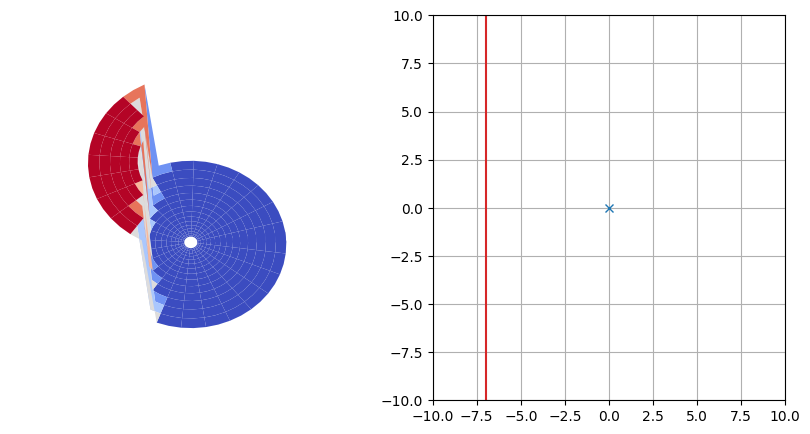

In [71]:
# polygon = np.array([[-5, 5], [-5, 7.5], [5, 7.5], [5, 5]])

polygon = np.array([[-20, -20], [-20, 20], [-7, 20], [-7, -20]])


result = points_in_polygon(pdist, pang, x_bvc, y_bvc, polygon)


fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

ax1.plot_surface(
    x_bvc,
    y_bvc,
    result,
    cmap='coolwarm'
)
ax1.view_init(azim=-90, elev=60)
ax1.set_axis_off()


ax2.set_xlim(-10, 10)
ax2.set_ylim(-10, 10)
_ = plot_polygon(Polygon(polygon), ax=ax2)
ax2.plot(0, 0, 'x')
ax2.grid()

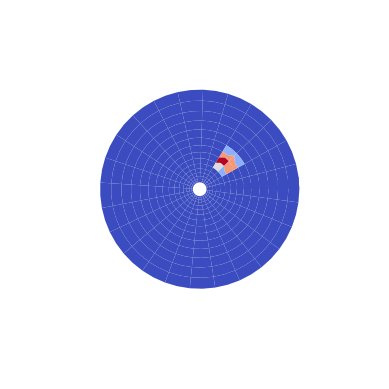

In [54]:
%matplotlib inline
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.plot_surface(
    x_bvc,
    y_bvc,
    result,
    cmap='coolwarm'
)
ax.view_init(azim=-90, elev=90)
ax.set_axis_off()

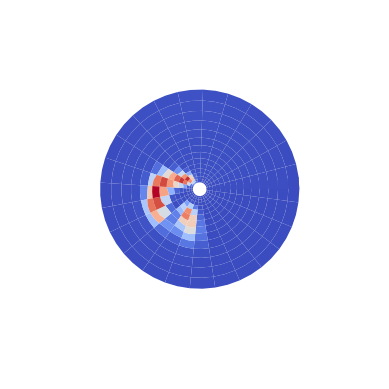

In [52]:
%matplotlib inline
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.plot_surface(
    x_bvc,
    y_bvc,
    np.reshape(cache['rates'].bvc, (cache['tc_gen'].n_bvc_theta, cache['tc_gen'].n_bvc_r)),
    cmap='coolwarm'
)
ax.view_init(azim=-90, elev=90)
ax.set_axis_off()

In [ ]:
from bbtoolkit.structures.geometry import Coordinates2D


location = 500
pos_x = env.params.coords[location, 0]
pos_y = env.params.coords[location, 1]
all_visible_parts_x, all_visible_parts_y, all_non_nan_indices, all_boundary_point_texture = [], [], [], []

for wall in env.walls:

    visible_parts_x = wall.visible_parts[location, :, 0]
    visible_parts_y = wall.visible_parts[location, :, 1]
    non_nan_indices = np.where(~np.isnan(visible_parts_x))[0]
    boundary_point_texture = wall.polygon.texture.id_*np.ones_like(non_nan_indices)
    all_visible_parts_x.append(visible_parts_x[non_nan_indices])
    all_visible_parts_y.append(visible_parts_y[non_nan_indices])
    all_non_nan_indices.append(non_nan_indices)
    all_boundary_point_texture.append(boundary_point_texture)

visible_parts_x = np.concatenate(all_visible_parts_x)
visible_parts_y = np.concatenate(all_visible_parts_y)
visible_boundary_points = Coordinates2D(
    visible_parts_x - pos_x,
    visible_parts_y - pos_y
)
non_nan_indices = np.concatenate(all_non_nan_indices)
boundary_point_texture = np.concatenate(all_boundary_point_texture)


In [15]:
class OVCCallback(BaseCallback):
    #
    def on_step_begin(self, step: int):
        # % Object Vector Cells
        # k_OVC = -OVCact + OVC2OVCphi * OVC2OVCwts * OVC_rate + ...            % OVC to OVC is purely inhibitory
        #     bleed * Imod * H2OVCphi * H2OVCwts * H_rate + ... #! IGNORE IMAG PART
        #     BVC2OVCphi * BVC2OVCwts * BVC_rate + ...
        #     bleed * Imod * oPR2OVCphi * oPR2OVCwts * oPR_rate + ... #! IGNORE IMAG PART
        #     1/bleed * Pmod * TR2OVCphi * TR2BVCwts * ( oTR_rate1 + ...
        #     oTR_rate2 + oTR_rate3 + oTR_rate4 + oTR_rate5 + oTR_rate6 + oTR_rate7 + ...
        #     oTR_rate8 + oTR_rate9 + oTR_rate10 + oTR_rate11 + oTR_rate12 + oTR_rate13 + ...
        #     oTR_rate14 + oTR_rate15 + oTR_rate16 + oTR_rate17 + oTR_rate18 + oTR_rate19 + oTR_rate20 );

        # OVCact   = OVCact   + dt/OVCtau*k_OVC;

        # OVC_rate   = 1./(1+exp(-2*OVCbeta*(OVCact-OVCalpha)));

        self.cache['k_ratio'].ovc = -self.cache['activity'].ovc +\
            self.cache['connectivity'].ovc.to.ovc['phi']*self.cache['weights'].ovc.to.ovc @ self.cache['rates'].ovc +\
            self.cache['connectivity'].bvc.to.ovc['phi']*self.cache['weights'].bvc.to.ovc @ self.cache['rates'].bvc +\
            self.cache['connectivity'].tr.to.ovc['phi']*self.cache['weights'].tr.to.bvc @ np.sum(self.cache['rates'].otr, axis=0)

        self.cache['activity'].ovc += self.cache['dt']/self.cache['connectivity'].ovc.to.ovc['tau']*self.cache['k_ratio'].ovc

        self.cache['rates'].ovc = 1/(1 + np.exp(-2*self.cache['connectivity'].ovc.to.ovc['beta']*(self.cache['activity'].ovc - self.cache['connectivity'].ovc.to.ovc['alpha'])))


        # update weights

        # % OVC2H and H2OVC weights
        # OVC2Hwts_after    = OVC2Hwts;
        # Hact_for_update   = max(Hact,0);                                   % because of negative activations
        # OVCact_for_update = max(OVCact,0);
        # OVCact_for_update(OVCact_for_update<0.05) = 0;                     % ...
        # OVC_x_H_act       = Hact_for_update*OVCact_for_update';
        # OVC_x_H_act       = OVC_x_H_act/max(max(OVC_x_H_act));             % normalize
        # tmp1              = (OVC_x_H_act>0.05);                            % rate threshold, eliminate background
        # OVC2Hwts_after(tmp1) = OVC2Hwts(tmp1) + OVC_x_H_act(tmp1);
        # OVC2Hwts             = OVC2Hwts_after;
        # H2OVCwts = OVC2Hwts';

        h_act = np.maximum(self.cache['activity'].h, 0)
        ovc_act = np.maximum(self.cache['activity'].ovc, 0)
        ovc_act[ovc_act < 0.05] = 0
        ovc_x_h_act = h_act @ ovc_act.T

        max_act = np.max(ovc_x_h_act)
        if np.isclose(max_act, 0):
            max_act = 1

        ovc_x_h_act = ovc_x_h_act / max_act
        tmp1 = ovc_x_h_act > 0.05
        self.cache['weights'].ovc.to.h[tmp1] += ovc_x_h_act[tmp1]
        self.cache['weights'].h.to.ovc = self.cache['weights'].ovc.to.h.T

In [16]:
def get_pr_cue(env: Environment, walls_fov: list[np.ndarray]) -> np.ndarray:
    # 1. get amount of points for each texture id
    counts = dict()
    distances = dict()
    for wall, wall_fov in zip(env.walls, walls_fov):
        if wall.polygon.texture.id_ not in counts:
            counts[wall.polygon.texture.id_] = len(wall_fov)
            d = np.sqrt(np.sum(wall_fov**2, axis=1))
            if d.size:
                distances[wall.polygon.texture.id_] = np.min(d)
            else:
                distances[wall.polygon.texture.id_] = np.inf
        else:
            counts[wall.polygon.texture.id_] += len(wall_fov)
            distances[wall.polygon.texture.id_] = min(distances[wall.polygon.texture.id_], np.min(np.sqrt(np.sum(wall_fov**2, axis=1))))

    distances = dict(sorted(distances.items(), key=lambda x: x[0])) # walls with smallest id first
    counts = dict(sorted(counts.items(), key=lambda x: x[0]))
    # 2. get the pr cue vector which is counts normalized by the distance
    pr_cue = np.array([count/dist for count, dist in zip(counts.values(), distances.values())])

    return pr_cue

In [17]:
class PRCallback(BaseCallback):
    #
    def on_step_begin(self, step: int):
        # % Perirhinal Identity Neurons (boundary specific)
        # k_PR = -PRact + PR2PRwts * PR_rate + ...
        #     Imod * H2PRphi * H2PRwts * H_rate + ... #! IGNORE IMAG PART
        #     BVC2PRphi * BVC2PRwts * BVC_rate + (CueDur>step) * PRCue + PRcue_percep;   % PRCue will always be zero except at start

        # PRact   = PRact   + dt/PRtau*k_PR;

        # PR_rate   = 1./(1+exp(-2*PRbeta*(PRact-PRalpha)));

        pr_cue = get_pr_cue(self.cache['env'], self.cache['walls_fov'])[:, np.newaxis]

        #FIXME: 50 is hardcoded
        self.cache['pr_cue'] = 50*pr_cue/np.max(pr_cue)

        self.cache['k_ratio'].pr = -self.cache['activity'].pr +\
            self.cache['connectivity'].pr.to.pr['phi']*self.cache['weights'].pr.to.pr @ self.cache['rates'].pr +\
            self.cache['connectivity'].bvc.to.pr['phi']*self.cache['weights'].bvc.to.pr @ self.cache['rates'].bvc +\
            self.cache['pr_cue']

        self.cache['activity'].pr += self.cache['dt']/self.cache['connectivity'].pr.to.pr['tau']*self.cache['k_ratio'].pr

        self.cache['rates'].pr = 1/(1 + np.exp(-2*self.cache['connectivity'].pr.to.pr['beta']*(self.cache['activity'].pr - self.cache['connectivity'].pr.to.pr['alpha'])))

In [18]:
class oPRCallback(BaseCallback):
    def __init__(self):
        self.opr_cue = None

    def set_cache(self, cache: Mapping):
        super().set_cache(cache)
        self.requires = [
            'env',
            'connectivity',
            'weights',
            'rates'
        ]
        self.opr_cue = np.zeros((len(self.cache['env'].objects), 1))

    def on_step_begin(self, step: int):
        # % Perirhinal Identity Neurons (object specific)
        # k_oPR = -oPRact + (oPR2oPRphi * oPR2oPRwts * oPR_rate + ...
        #     H2oPRphi * H2oPRwts * H_rate + ...
        #     OVC2oPRphi * OVC2oPRwts * OVC_rate + ...
        #     recallobj * oPRCue ).* pseudoadap + percep_flag*200*oPR_drive;   % added actual PR drive, drive 0 during imagery
        #   #! no recall      no pseudo-adaptation  percep=True
        # oPRact   = oPRact   + dt/PRtau*k_oPR;

        # oPR_rate   = 1./(1+exp(-2*PRbeta*(oPRact-PRalpha)));

        self.opr_cue *= 0
        self.opr_cue[self.cache['attend_to']] = 1 # currently one oPR neuron per object, however it can depend on texture

        self.cache['k_ratio'].opr = -self.cache['activity'].opr +\
            (
                self.cache['connectivity'].opr.to.opr['phi']*self.cache['weights'].opr.to.opr @ self.cache['rates'].opr +
                self.cache['connectivity'].h.to.opr['phi']*self.cache['weights'].h.to.opr @ self.cache['rates'].h +
                self.cache['connectivity'].ovc.to.opr['phi']*self.cache['weights'].ovc.to.opr @ self.cache['rates'].ovc
            ) + 200*self.opr_cue # FIXME: 200 is hardcoded

        self.cache['activity'].opr  = self.cache['dt']/self.cache['connectivity'].pr.to.pr['tau']*self.cache['k_ratio'].opr

        self.cache['rates'].opr = 1/(1 + np.exp(-2*self.cache['connectivity'].pr.to.pr['beta']*(self.cache['activity'].opr - self.cache['connectivity'].pr.to.pr['alpha'])))

        # update weights

        # % oPR2OVC and OVC2oPR weights
        # OVC2oPRwts_after    = OVC2oPRwts;
        # oPRact_for_update   = max(oPRact,0);                               % because of negative activations
        # OVCact_for_update   = max(OVCact,0);                               % ...
        # OVCact_for_update(OVCact_for_update<0.05) = 0;
        # OVC_x_oPR_act       = oPRact_for_update*OVCact_for_update';
        # OVC_x_oPR_act       = OVC_x_oPR_act/max(max(OVC_x_oPR_act));       % normalize
        # tmp1              = (OVC_x_oPR_act>0.05);                          % rate threshold, eliminate background
        # OVC2oPRwts_after(tmp1) = OVC2oPRwts(tmp1) + OVC_x_oPR_act(tmp1);
        # OVC2oPRwts             = OVC2oPRwts_after;
        # oPR2OVCwts = OVC2oPRwts';

        ovc_act = np.maximum(self.cache['activity'].ovc, 0)
        opr_act = np.maximum(self.cache['activity'].opr, 0)
        ovc_act[ovc_act < 0.05] = 0
        ovc_x_opr_act = opr_act @ ovc_act.T
        max_act = np.max(ovc_x_opr_act)
        if np.isclose(max_act, 0):
            max_act = 1
        ovc_x_opr_act = ovc_x_opr_act / max_act
        tmp1 = ovc_x_opr_act > 0.05
        self.cache['weights'].ovc.to.opr[tmp1] += ovc_x_opr_act[tmp1]
        self.cache['weights'].opr.to.ovc = self.cache['weights'].ovc.to.opr.T

        # % oPR2H  weights
        # oPR2Hwts_after    = oPR2Hwts;
        # oPRact_for_update = max(oPRact,0);                                 % because of negative activations
        # Hact_for_update   = max(Hact,0);                                   % ...
        # H_x_oPR_act       = oPRact_for_update*Hact_for_update';
        # H_x_oPR_act       = H_x_oPR_act/max(max(H_x_oPR_act));             % normalize
        # oPR_x_H_act       = H_x_oPR_act';
        # tmp1              = (oPR_x_H_act>0.2);                             % individual thresh
        # oPR2Hwts_after(tmp1) = oPR2Hwts(tmp1) + oPR_x_H_act(tmp1);
        # oPR2Hwts             = oPR2Hwts_after;
        # H2oPRwts = oPR2Hwts';

        h_act = np.maximum(self.cache['activity'].h, 0)
        opr_act = np.maximum(self.cache['activity'].opr, 0)
        h_x_opr_act = opr_act @ h_act.T
        max_act = np.max(h_x_opr_act)
        if np.isclose(max_act, 0):
            max_act = 1
        h_x_opr_act = h_x_opr_act / max_act
        opr_x_h_act = h_x_opr_act.T
        tmp1 = opr_x_h_act > 0.2
        self.cache['weights'].opr.to.h[tmp1] += opr_x_h_act[tmp1]
        self.cache['weights'].h.to.opr = self.cache['weights'].opr.to.h.T

        # % oID to HD
        # oPR2HDwts_after   = oPR2HDwts;
        # oPRact_for_update = max(oPRact,0);                                 % because of negative activations
        # HDact_for_update  = max(HDact,0);
        # HD_x_oPR_act      = oPRact_for_update*HDact_for_update';
        # oPR_x_HD_act      = HD_x_oPR_act';
        # oPR_x_HD_act      = oPR_x_HD_act/max(max(oPR_x_HD_act));           % normalize
        # tmp1              = (oPR_x_HD_act>0.2);                            % individual thresh
        # oPR2HDwts_after(tmp1) = oPR2HDwts(tmp1) + oPR_x_HD_act(tmp1);
        # oPR2HDwts             = oPR2HDwts_after;

        hd_act = np.maximum(self.cache['activity'].hd, 0)
        hd_x_opr_act = opr_act @ hd_act.T
        opr_x_hd_act = hd_x_opr_act.T
        max_act = np.max(opr_x_hd_act)
        if np.isclose(max_act, 0):
            max_act = 1
        opr_x_hd_act = opr_x_hd_act / max_act
        tmp1 = opr_x_hd_act > 0.2
        self.cache['weights'].opr.to.hd[tmp1] += opr_x_hd_act[tmp1]


In [19]:
class PWCallback(BaseCallback):
    def on_step_begin(self, step: int):
        # k_PW = -PWact - 100*PW_bath + ...
        # bleed * Imod * TR2PWphi * (TR2PWwts1 * TR_rate1 + ...     #! IGNORE IMAG PART
        # TR2PWwts2*TR_rate2 + TR2PWwts3*TR_rate3 + TR2PWwts4*TR_rate4 + TR2PWwts5*TR_rate5 + ...
        # TR2PWwts6*TR_rate6 + TR2PWwts7*TR_rate7 + TR2PWwts8*TR_rate8 + TR2PWwts9*TR_rate9 + ...
        # TR2PWwts10*TR_rate10 + TR2PWwts11*TR_rate11 + TR2PWwts12*TR_rate12 + TR2PWwts13*TR_rate13 + ...
        # TR2PWwts14*TR_rate14 + TR2PWwts15*TR_rate15 + TR2PWwts16*TR_rate16 + TR2PWwts17*TR_rate17 + ...
        # TR2PWwts18*TR_rate18 + TR2PWwts19*TR_rate19 + TR2PWwts20*TR_rate20) + 1/(min(bleed,2)) ...
        # * BcueScale * EgoCue_percep;

        # PWact    = PWact    + dt/PWtau*k_PW;

        # PW_rate    = 1./(1+exp(-2*PWbeta*(PWact-PWalpha)));

        # FIXME: 100 is hardcoded
        self.cache['k_ratio'].pw = -self.cache['activity'].pw - 100*self.cache['connectivity'].pw.to.pw['inhibitory_phi'] +\
            np.sum(np.transpose(self.cache['weights'].tr.to.pw, (2, 0, 1)) @ self.cache['rates'].tr, axis=0) +\
            1.6*30*np.sum(self.cache['walls_pw'], axis=0)[:, np.newaxis] # FIXME: 1.6 is BcueScale, 30 is hardcoded

        self.cache['activity'].pw += self.cache['dt']/self.cache['connectivity'].pw.to.pw['tau']*self.cache['k_ratio'].pw

        self.cache['rates'].pw = 1/(1 + np.exp(-2*self.cache['connectivity'].pw.to.pw['beta']*(self.cache['activity'].pw - self.cache['connectivity'].pw.to.pw['alpha'])))


In [20]:
class oPWCallback(BaseCallback):
    def __init__(self):
        super().__init__()
        self.objects_pw_cue = 0
        self.attn_prev = None
    def on_step_begin(self, step: int):
        # k_oPW = -oPWact - sum(oPW_rate) * oPW_bath + ...
        # bleed * Imod * TR2oPWphi * (TR2PWwts1 * oTR_rate1 + ... #! IGNORE IMAG PART
        # TR2PWwts2*oTR_rate2 + TR2PWwts3*oTR_rate3 + TR2PWwts4*oTR_rate4 + TR2PWwts5*oTR_rate5 + ...
        # TR2PWwts6*oTR_rate6 + TR2PWwts7*oTR_rate7 + TR2PWwts8*oTR_rate8 + TR2PWwts9*oTR_rate9 + ...
        # TR2PWwts10*oTR_rate10 + TR2PWwts11*oTR_rate11 + TR2PWwts12*oTR_rate12 + TR2PWwts13*oTR_rate13 + ...
        # TR2PWwts14*oTR_rate14 + TR2PWwts15*oTR_rate15 + TR2PWwts16*oTR_rate16 + TR2PWwts17*oTR_rate17 + ...
        # TR2PWwts18*oTR_rate18 + TR2PWwts19*oTR_rate19 + TR2PWwts20*oTR_rate20) + 1/(min(bleed,2)) ...
        # * OcueScale * ObjCue_percep + 1 * ObjCue_allocATT; #! AllocATT is 0 for now

        # oPWact   = oPWact   + dt/oPWtau*k_oPW;

        # oPW_rate   = 1./(1+exp(-2*oPWbeta*(oPWact-oPWalpha)));
        self.objects_pw_cue = 0.3*100*self.cache['objects_pw'][self.cache['attend_to']][:, np.newaxis] if self.cache['attend_to'] is not None else 0

        # self.objects_pw_cue = 0.3*100*self.cache['objects_pw'][self.cache['attend_to']][:, np.newaxis] if self.cache['attend_to'] is not None else self.objects_pw_cue

        self.cache['k_ratio'].opw = -self.cache['activity'].opw - np.sum(self.cache['rates'].opw) * self.cache['connectivity'].opw.to.opw['inhibitory_phi']*20 +\
            np.sum(np.transpose(self.cache['weights'].tr.to.pw, (2, 0, 1)) @ self.cache['rates'].otr, axis=0) +\
            self.objects_pw_cue# FIXME: 0.3 is OcueScale, 100 is hardcoded

        self.cache['activity'].opw += self.cache['dt']/self.cache['connectivity'].opw.to.opw['tau']*self.cache['k_ratio'].opw

        self.cache['rates'].opw = 1/(1 + np.exp(-2*self.cache['connectivity'].opw.to.opw['beta']*(self.cache['activity'].opw - self.cache['connectivity'].opw.to.opw['alpha'])))

        if self.attn_prev != self.cache['attend_to']:
            self.attn_prev = self.cache['attend_to']
            print('Switch attention to', self.cache['attend_to'])

In [21]:
from typing import Mapping


class IPRateCallback(BaseCallback):
    def set_cache(self, cache: Mapping):
        super().set_cache(cache)
        self.requires = [
            'connectivity',
            'rates'
        ]

    def on_step_begin(self, step: int):
        # IPrate = 1./(1+exp(-2*IPbeta*(HD2IPphi*sum(HD_rate)-IPalpha)));

        self.cache['rates'].ip = 1/(1 + np.exp(-2*self.cache['connectivity'].ip.to.ip['beta']*(self.cache['connectivity'].hd.to.ip['phi']*np.sum(self.cache['rates'].hd) - self.cache['connectivity'].ip.to.ip['alpha'])))


class TCCallback(BaseCallback):

    def set_cache(self, cache: Mapping):
        super().set_cache(cache)
        self.requires = [
            'connectivity',
            'rates',
            'activity',
            'weights',
            'dt'
        ]
    def on_step_begin(self, step: int):
        # for i = 1:20
        #     k_TR (i)  = -TRact (i)  - sum(TR_rate (i))  * TR_bath +
        #       HD2TRphi*HD2TRwts(:,:, i) * HD_rate
        #       - IP2TRphi*IPrate +
        #       Imod*BVC2TRphi*BVC2TR + #! IGNORE IMAG PART
        #       1/bleed * Pmod*PW2TRphi*PW2TRwts (i) '*PW_rate;']);
        # end

        # for i = 1:20
        #     eval(['TRact' int2str(i) ' = TRact' int2str(i) ' + dt/TRtau*k_TR' int2str(i) ';']);
        # end

        # for i = 1:20
        #     eval(['TR_rate' int2str(i) ' = 1./(1+exp(-2*TRbeta*(TRact' int2str(i) '-TRalpha)));']);
        # end

        # for i in range(self.cache['rates'].tr.shape[0]):
        #     self.cache['k_ratio'].tr[i] = -self.cache['activity'].tr[i] - np.sum(self.cache['rates'].tr[i]) * self.cache['connectivity'].tr.to.tr['inhibitory_phi'] +\
        #         self.cache['connectivity'].hd.to.tr['phi']*self.cache['weights'].hd.to.tr[:, :, i] @ self.cache['rates'].hd -\
        #         self.cache['connectivity'].ip.to.tr['phi']*self.cache['rates'].ip +\
        #         self.cache['connectivity'].pw.to.tr['phi']*self.cache['weights'].pw.to.tr[:, :, i] @ self.cache['rates'].pw

        self.cache['k_ratio'].tr = (
            -self.cache['activity'].tr
            - np.sum(self.cache['rates'].tr, axis=0) * self.cache['connectivity'].tr.to.tr['inhibitory_phi']
            + self.cache['connectivity'].hd.to.tr['phi']*np.transpose(self.cache['weights'].hd.to.tr, (2, 0, 1)) @ self.cache['rates'].hd
            - self.cache['connectivity'].ip.to.tr['phi']*self.cache['rates'].ip
            + self.cache['connectivity'].pw.to.tr['phi']*np.transpose(self.cache['weights'].pw.to.tr, (2, 0, 1)) @ self.cache['rates'].pw
        )

        self.cache['activity'].tr += self.cache['dt']/self.cache['connectivity'].tr.to.tr['tau']*self.cache['k_ratio'].tr

        self.cache['rates'].tr = 1/(1 + np.exp(-2*self.cache['connectivity'].tr.to.tr['beta']*(self.cache['activity'].tr - self.cache['connectivity'].tr.to.tr['alpha'])))

In [22]:
class oTCCallback(BaseCallback):

    def set_cache(self, cache: Mapping):
        super().set_cache(cache)
        self.requires = [
            'connectivity',
            'rates',
            'activity',
            'weights',
            'dt'
        ]

    def on_step_begin(self, step: int):
        # for i = 1:20
        #     k_oTR (i) '  = -oTRact(i) - sum(oTR_rate (i))  * oTR_bath +
        #         HD2TRphi*HD2TRwts(:,:,i) * HD_rate
        #         - IP2oTRphi*IPrate +
        #         Imod*BVC2TRphi*OVC2TR + #! IGNORE IMAG PART
        #         1/bleed * Pmod*oPW2TRphi*PW2TRwts (i)*oPW_rate;']);
        # end

        # for i = 1:20
        #     eval(['TRact' int2str(i) ' = TRact' int2str(i) ' + dt/TRtau*k_TR' int2str(i) ';']);
        # end

        # for i = 1:20
        #     eval(['TR_rate' int2str(i) ' = 1./(1+exp(-2*TRbeta*(TRact' int2str(i) '-TRalpha)));']);
        # end

        self.cache['k_ratio'].otr = (
            - self.cache['activity'].otr
            - np.sum(self.cache['rates'].otr, axis=0) * self.cache['connectivity'].otr.to.otr['inhibitory_phi']
            + self.cache['connectivity'].hd.to.tr['phi']*np.transpose(self.cache['weights'].hd.to.tr, (2, 0, 1)) @ self.cache['rates'].hd
            - self.cache['connectivity'].ip.to.otr['phi']*self.cache['rates'].ip
            + self.cache['connectivity'].opw.to.tr['phi']*np.transpose(self.cache['weights'].pw.to.tr, (2, 0, 1)) @ self.cache['rates'].opw
        )

        self.cache['activity'].otr += self.cache['dt']/self.cache['connectivity'].otr.to.otr['tau']*self.cache['k_ratio'].otr

        self.cache['rates'].otr = 1/(1 + np.exp(-2*self.cache['connectivity'].tr.to.tr['beta']*(self.cache['activity'].otr - self.cache['connectivity'].tr.to.tr['alpha'])))

In [23]:
%matplotlib qt


from copy import deepcopy

dt = .005
position = (-4, 7.5)
direction = 0

cache['k_ratio'] = k_ratio.copy()
cache['activity'] = activity.copy()
cache['rates'] = rates.copy()
cache['weights'] = weights.copy()
cache['weights'].tr.to.bvc = np.eye(len(weights.tr.to.bvc))
cache['weights'].bvc.to.tr = np.eye(len(weights.tr.to.bvc))
cache['connectivity'] = connectivity.copy()
cache['dt'] = dt

dynamics = DynamicsManager(
    dt,
    callbacks=[
        MovementCallback(
            MovementManager(
                5,
                math.pi*2,
                position,
                direction
                # np.pi/2
            )
        ),
        FOVCallback(fov_manager),
        EgoCallback(ego_manager),
        EgoSegmentationCallback(),
        ParietalWindowCallback(),
        PlottingCallback(x_bvc, y_bvc, 10),
        MovementSchedulerCallback(),
        TrajectoryCallback(
            AStarTrajectory(
                compiler.environment,
                n_points=5,
                method='quadratic',
                dx=.5,
                poly_increase_factor=1.2
            )
        ),
        AttentionCallback(RhythmicAttention(7, dt, len(compiler.environment.objects))),
        HeadDirectionCallback(),
        GCRateCallback(gc_map),
        PCCallback(),
        BVCCallback(),
        OVCCallback(),
        PRCallback(),
        oPRCallback(),
        PWCallback(),
        oPWCallback(),
        IPRateCallback(),
        TCCallback(),
        oTCCallback()
    ],
    cache=cache
)


for _ in dynamics(100):
    print('out: ', _)

QApplication: invalid style override 'kvantum' passed, ignoring it.
	Available styles: Windows, Fusion


Switch attention to 4
HD CUE REMOVED
out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
Switch attention to None
out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
Switch attention to 4
Switch attention to None
Switch attention to 4
Switch attention to None
out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
Switch attention to 0
Switch attention to 1
Switch attention to 2
Switch attention to 0
Switch attention to 1
Switch attention to 2
Switch attention to 3
Switch attention to 0
out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
Switch attention to 1
Switch attention to 2
Switch attention to 3
Switch attention to 0
Switch attention to 1
Switch attention to 3
Swit

KeyboardInterrupt: 

In [24]:
cache['rates'].h.shape

(4356, 1)

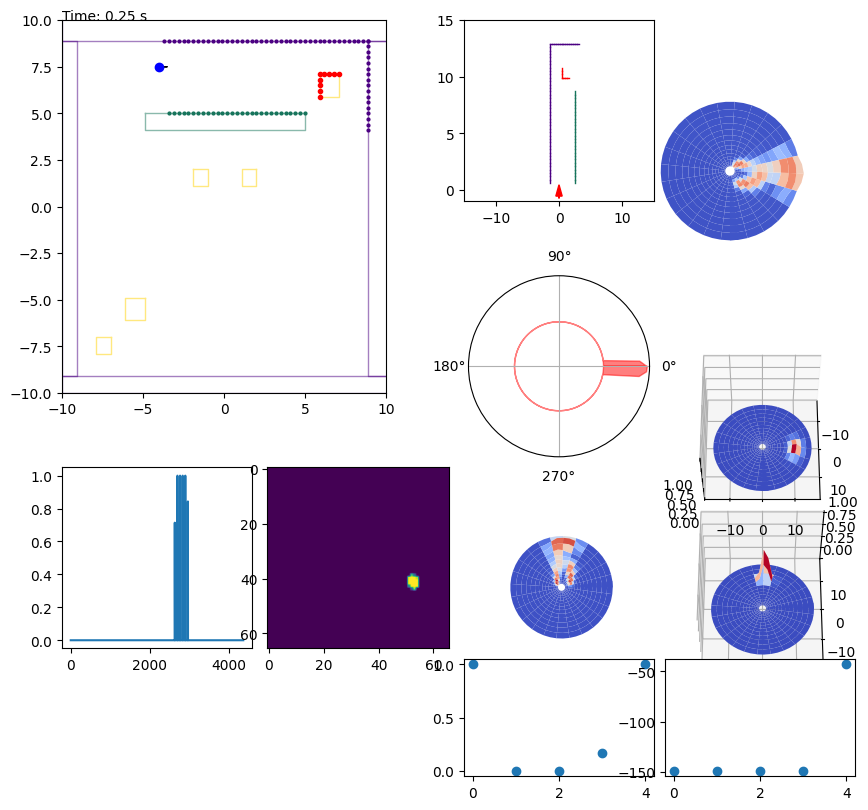

In [24]:
%matplotlib inline
plt.show()

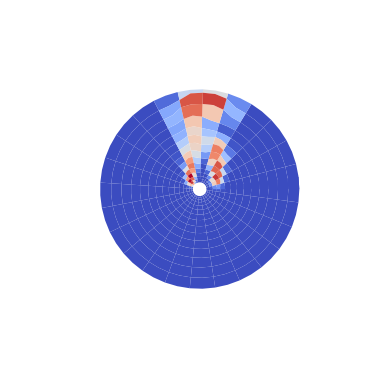

In [28]:
%matplotlib inline
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.plot_surface(
    x_bvc,
    y_bvc,
    np.reshape(cache['rates'].pw, (cache['tc_gen'].n_bvc_theta, cache['tc_gen'].n_bvc_r)),
    cmap='coolwarm'
)
ax.view_init(azim=-90, elev=90)
ax.set_axis_off()

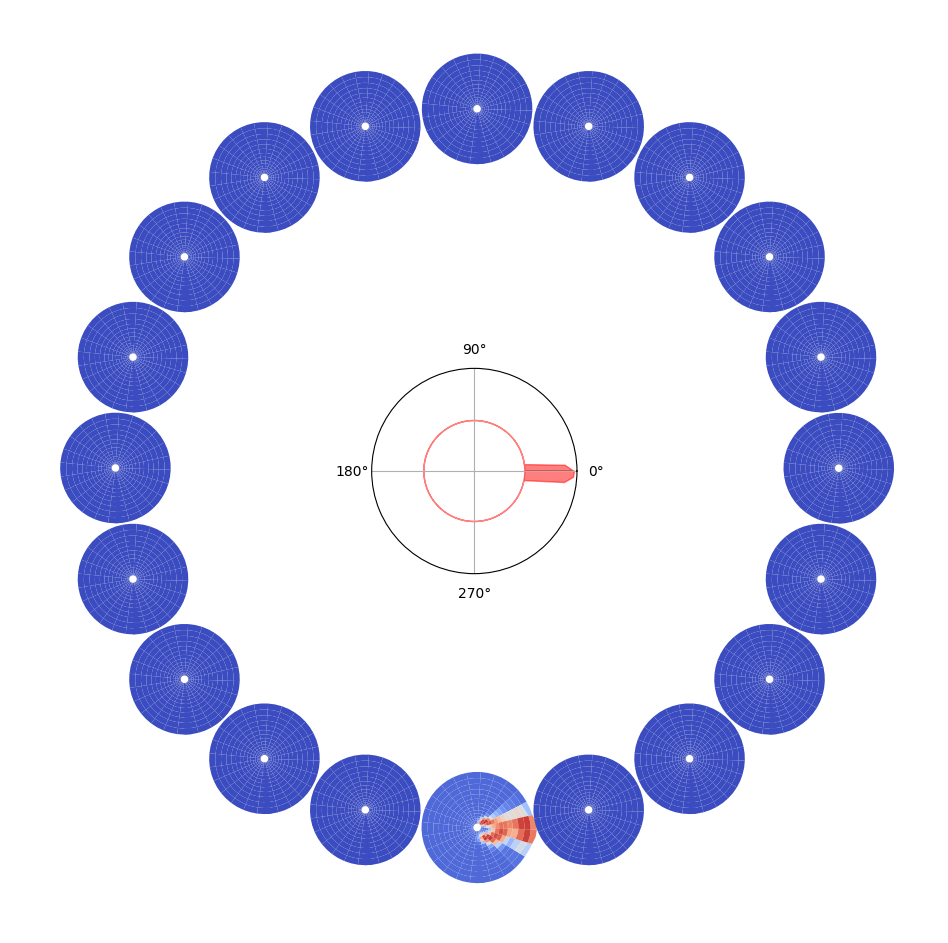

In [27]:
fig, axs = create_circular_layout(20, 3.5, (20, 20))

for ax in axs:
    ax.set_facecolor((0.0, 0.0, 0.0, 0))


# axs[0].set_theta_zero_location('S')
axs[0].set_theta_direction(-1)
axs[0].set_xticks(np.linspace(0, 2*np.pi, 4, endpoint=False))
axs[0].set_xticklabels(['0°', '270°', '180°', '90°'])
axs[0].axes.get_yaxis().set_visible(False)

theta = np.linspace(0, 2*np.pi, len(cache['hd_cue']))
low = np.ones(len(cache['hd_cue']))/2
high = np.squeeze(cache['rates'].hd)
fill_condition = np.where(high >= low, high, low)
axs[0].fill(np.concatenate([theta, theta[::-1]]), np.concatenate([low, fill_condition]), color='red', alpha=0.5)

tc_axes = axs[1:]

for i in range(20):

    # ind = (i + 5) % 20
    ind = (i) % 20

    tc_axes[ind].plot_surface(
        x_bvc,
        y_bvc,
        np.reshape(cache['rates'].tr[i], (cache['tc_gen'].n_bvc_theta, cache['tc_gen'].n_bvc_r)),
        cmap='coolwarm',
        vmin=0,
        vmax=1
    )
    tc_axes[ind].view_init(azim=0, elev=90)
    tc_axes[ind].set_axis_off()
    tc_axes[ind].set_zlim(0, cache['rates'].tr.max())

plt.show()

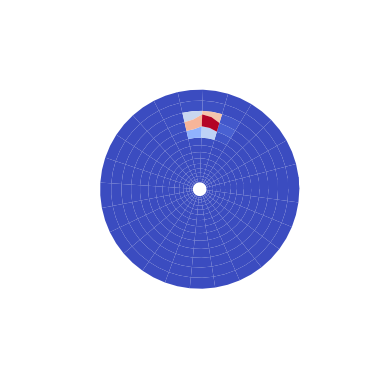

In [24]:
%matplotlib inline
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.plot_surface(
    x_bvc,
    y_bvc,
    np.reshape(cache['rates'].opw, (cache['tc_gen'].n_bvc_theta, cache['tc_gen'].n_bvc_r)),
    cmap='coolwarm'
)
ax.view_init(azim=-90, elev=90)
ax.set_axis_off()

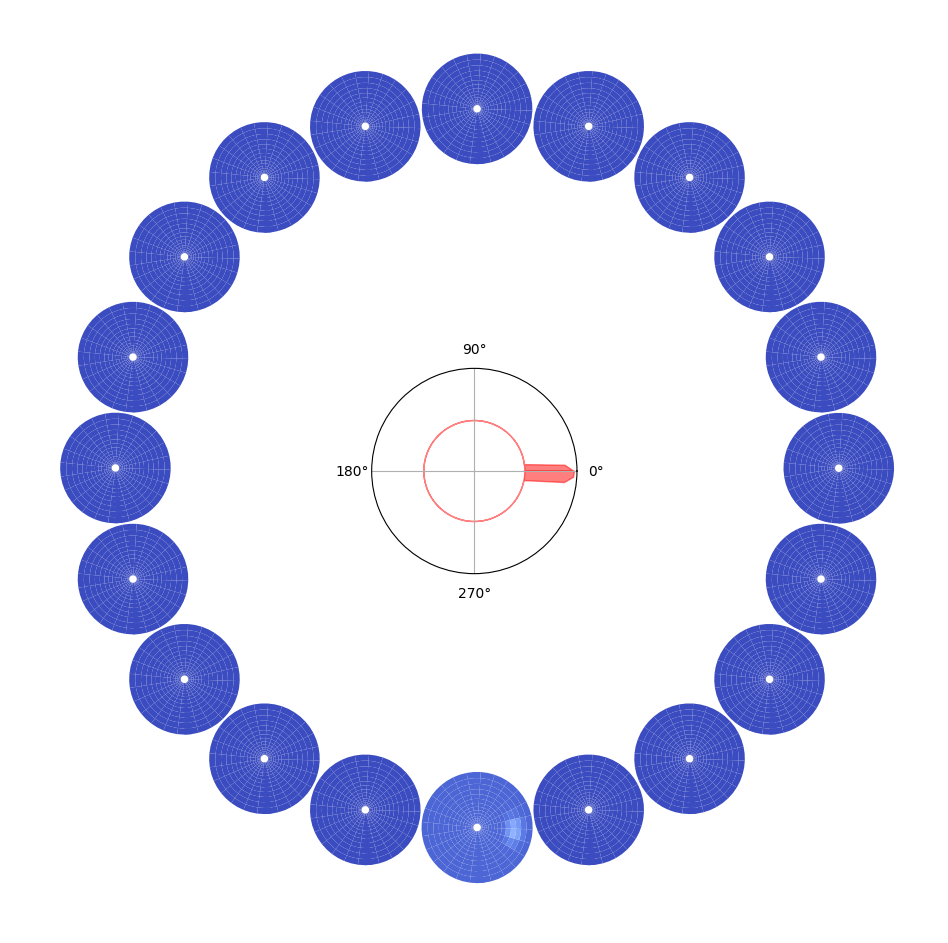

In [36]:
fig, axs = create_circular_layout(20, 3.5, (20, 20))

for ax in axs:
    ax.set_facecolor((0.0, 0.0, 0.0, 0))


# axs[0].set_theta_zero_location('S')
axs[0].set_theta_direction(-1)
axs[0].set_xticks(np.linspace(0, 2*np.pi, 4, endpoint=False))
axs[0].set_xticklabels(['0°', '270°', '180°', '90°'])
axs[0].axes.get_yaxis().set_visible(False)

theta = np.linspace(0, 2*np.pi, len(cache['hd_cue']))
low = np.ones(len(cache['hd_cue']))/2
high = np.squeeze(cache['rates'].hd)
fill_condition = np.where(high >= low, high, low)
axs[0].fill(np.concatenate([theta, theta[::-1]]), np.concatenate([low, fill_condition]), color='red', alpha=0.5)

tc_axes = axs[1:]

for i in range(20):

    # ind = (i + 5) % 20
    ind = (i) % 20

    tc_axes[ind].plot_surface(
        x_bvc,
        y_bvc,
        np.reshape(cache['rates'].otr[i], (cache['tc_gen'].n_bvc_theta, cache['tc_gen'].n_bvc_r)),
        cmap='coolwarm',
        # vmax=cache['rates'].otr.max()
        vmin=0,
        vmax=1
    )
    tc_axes[ind].view_init(azim=0, elev=90)
    tc_axes[ind].set_axis_off()
    tc_axes[ind].set_zlim(0, cache['rates'].tr.max())

plt.show()

In [38]:
cache['activity'].otr.max()

0.29823515316342675